### Compare two images

This method is to use algorithms such as Mean Squared Error(MSE) or the Structural Similarity Index(SSIM).

$$MSE = \frac{1}{m n}\cdot\sum_{i=0}^{m-1}\cdot \sum_{j=0}^{n-1}\cdot \left [I(i,j) - K(i,j)  \right ]^{2}$$

In [1]:
def mse(img1, img2):
    '''The Mean Squared Error between the two images
    is the sum of the squared difference between the two images.
    Note: the two images must have the same dimension.
    '''
    import numpy as np
    err = np.sum((img1.astype('float') - img2.astype('float'))**2)
    err /= float(img1.shape[0]*img2.shape[1])
    
    # return the MSE, the lower the error, the more similar
    # the two images are.
    return err

$$SSIM\left ( x, y \right ) = \frac{(2*\mu_{x}\mu_{y} + c_{1})(2\sigma_{xy} + c_{2})}{(\mu_{x}^{2} + \mu_{y}^{2} + c_{1})(\sigma_{x}^{2} + \sigma_{y}^{2} + c_{2})}$$

In [2]:
import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter
def ssim(X, Y, win_size=None, gradient=False,
         data_range=None, multichannel=False, gaussian_weights=False,
         full=False, dynamic_range=None, **kwargs):
    """Compute the mean structural similarity index between two images.
    Parameters
    ----------
    X, Y : ndarray
        Image.  Any dimensionality.
    win_size : int or None
        The side-length of the sliding window used in comparison.  Must be an
        odd value.  If `gaussian_weights` is True, this is ignored and the
        window size will depend on `sigma`.
    gradient : bool, optional
        If True, also return the gradient.
    data_range : int, optional
        The data range of the input image (distance between minimum and
        maximum possible values).  By default, this is estimated from the image
        data-type.
    multichannel : bool, optional
        If True, treat the last dimension of the array as channels. Similarity
        calculations are done independently for each channel then averaged.
    gaussian_weights : bool, optional
        If True, each patch has its mean and variance spatially weighted by a
        normalized Gaussian kernel of width sigma=1.5.
    full : bool, optional
        If True, return the full structural similarity image instead of the
        mean value.
    Other Parameters
    ----------------
    use_sample_covariance : bool
        if True, normalize covariances by N-1 rather than, N where N is the
        number of pixels within the sliding window.
    K1 : float
        algorithm parameter, K1 (small constant, see [1]_)
    K2 : float
        algorithm parameter, K2 (small constant, see [1]_)
    sigma : float
        sigma for the Gaussian when `gaussian_weights` is True.
    Returns
    -------
    mssim : float
        The mean structural similarity over the image.
    grad : ndarray
        The gradient of the structural similarity index between X and Y [2]_.
        This is only returned if `gradient` is set to True.
    S : ndarray
        The full SSIM image.  This is only returned if `full` is set to True.
    Notes
    -----
    To match the implementation of Wang et. al. [1]_, set `gaussian_weights`
    to True, `sigma` to 1.5, and `use_sample_covariance` to False.
    References
    ----------
    .. [1] Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P.
       (2004). Image quality assessment: From error visibility to
       structural similarity. IEEE Transactions on Image Processing,
       13, 600-612.
       https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf,
       DOI:10.1.1.11.2477
    .. [2] Avanaki, A. N. (2009). Exact global histogram specification
       optimized for structural similarity. Optical Review, 16, 613-621.
       http://arxiv.org/abs/0901.0065,
       DOI:10.1007/s10043-009-0119-z
    """
    _integer_types = (np.byte, np.ubyte,          # 8 bits
                      np.short, np.ushort,        # 16 bits
                      np.intc, np.uintc,          # 16 or 32 or 64 bits
                      np.int_, np.uint,           # 32 or 64 bits
                      np.longlong, np.ulonglong)  # 64 bits
    _integer_ranges = {t: (np.iinfo(t).min, np.iinfo(t).max)
                       for t in _integer_types}
    dtype_range = {np.bool_: (False, True),
                   np.bool8: (False, True),
                   np.float16: (-1, 1),
                   np.float32: (-1, 1),
                   np.float64: (-1, 1)}
    dtype_range.update(_integer_ranges)
    
    if not X.dtype == Y.dtype:
        raise ValueError('Input images must have the same dtype.')

    if not X.shape == Y.shape:
        raise ValueError('Input images must have the same dimensions.')

    if dynamic_range is not None:
        warn('`dynamic_range` has been deprecated in favor of '
             '`data_range`. The `dynamic_range` keyword argument '
             'will be removed in v0.14', skimage_deprecation)
        data_range = dynamic_range

    if multichannel:
        # loop over channels
        args = dict(win_size=win_size,
                    gradient=gradient,
                    data_range=data_range,
                    multichannel=False,
                    gaussian_weights=gaussian_weights,
                    full=full)
        args.update(kwargs)
        nch = X.shape[-1]
        mssim = np.empty(nch)
        if gradient:
            G = np.empty(X.shape)
        if full:
            S = np.empty(X.shape)
        for ch in range(nch):
            ch_result = compare_ssim(X[..., ch], Y[..., ch], **args)
            if gradient and full:
                mssim[..., ch], G[..., ch], S[..., ch] = ch_result
            elif gradient:
                mssim[..., ch], G[..., ch] = ch_result
            elif full:
                mssim[..., ch], S[..., ch] = ch_result
            else:
                mssim[..., ch] = ch_result
        mssim = mssim.mean()
        if gradient and full:
            return mssim, G, S
        elif gradient:
            return mssim, G
        elif full:
            return mssim, S
        else:
            return mssim

    K1 = kwargs.pop('K1', 0.01)
    K2 = kwargs.pop('K2', 0.03)
    sigma = kwargs.pop('sigma', 1.5)
    if K1 < 0:
        raise ValueError("K1 must be positive")
    if K2 < 0:
        raise ValueError("K2 must be positive")
    if sigma < 0:
        raise ValueError("sigma must be positive")
    use_sample_covariance = kwargs.pop('use_sample_covariance', True)

    if win_size is None:
        if gaussian_weights:
            win_size = 11  # 11 to match Wang et. al. 2004
        else:
            win_size = 7   # backwards compatibility

    if np.any((np.asarray(X.shape) - win_size) < 0):
        raise ValueError(
            "win_size exceeds image extent.  If the input is a multichannel "
            "(color) image, set multichannel=True.")

    if not (win_size % 2 == 1):
        raise ValueError('Window size must be odd.')

    if data_range is None:
        dmin, dmax = dtype_range[X.dtype.type]
        data_range = dmax - dmin

    ndim = X.ndim

    if gaussian_weights:
        # sigma = 1.5 to approximately match filter in Wang et. al. 2004
        # this ends up giving a 13-tap rather than 11-tap Gaussian
        filter_func = gaussian_filter
        filter_args = {'sigma': sigma}

    else:
        filter_func = uniform_filter
        filter_args = {'size': win_size}

    # ndimage filters need floating point data
    X = X.astype(np.float64)
    Y = Y.astype(np.float64)

    NP = win_size ** ndim

    # filter has already normalized by NP
    if use_sample_covariance:
        cov_norm = NP / (NP - 1)  # sample covariance
    else:
        cov_norm = 1.0  # population covariance to match Wang et. al. 2004

    # compute (weighted) means
    ux = filter_func(X, **filter_args)
    uy = filter_func(Y, **filter_args)

    # compute (weighted) variances and covariances
    uxx = filter_func(X * X, **filter_args)
    uyy = filter_func(Y * Y, **filter_args)
    uxy = filter_func(X * Y, **filter_args)
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2

    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    D = B1 * B2
    S = (A1 * A2) / D

    # to avoid edge effects will ignore filter radius strip around edges
    pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim
    from numpy.lib.arraypad import _as_pairs
    ar = np.array(S, copy=False)
    crops = _as_pairs(pad, ar.ndim, as_index=True)
    slices = tuple(slice(a, ar.shape[i] - b) for i, (a, b) in enumerate(crops))
    cropped = ar[slices]
    # mssim = crop(S, pad).mean()
    mssim = cropped.mean()

    if gradient:
        # The following is Eqs. 7-8 of Avanaki 2009.
        grad = filter_func(A1 / D, **filter_args) * X
        grad += filter_func(-S / B2, **filter_args) * Y
        grad += filter_func((ux * (A2 - A1) - uy * (B2 - B1) * S) / D,
                            **filter_args)
        grad *= (2 / X.size)

        if full:
            return mssim, grad, S
        else:
            return mssim, grad
    else:
        if full:
            return mssim, S
        else:
            return mssim

In [3]:
#from skimage.measure import compare_mse, compare_ssim
import cv2
#import imutils
import matplotlib.pyplot as plt

SSIM: 0.9116000159993498


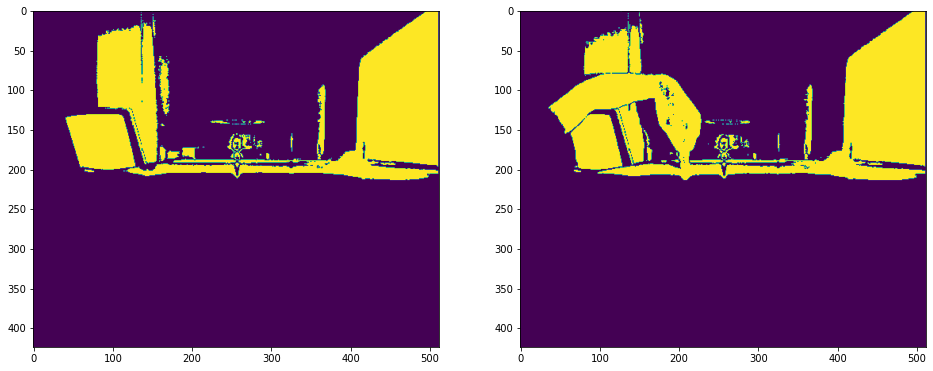

In [4]:
img1 = '/home/commaai-03/Test/tmp/data/depth_0_.png'
img2 = '/home/commaai-03/Test/tmp/data/depth_1_.png'

img1 = cv2.imread(img1) # RGB [...,::-1]
img2 = cv2.imread(img2)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(ncols=2, figsize=(16,12))
axs[0].imshow(gray1)
axs[1].imshow(gray2)

(score, diff) = ssim(gray1, gray2, full=True)
diff = (diff * 255).astype('uint8')
print('SSIM: {}'.format(score))

In [5]:
def show(frame_name, img):
    cv2.imshow(frame_name, img)
    k = cv2.waitKey(0)
    if k == 27 or k == ord('q'):
        cv2.destroyAllWindows()

In [6]:
#(score, diff) = compare_ssim(gray1, gray2, full=True)
(score, diff) = ssim(gray1, gray2, full=True)
diff = (diff * 255).astype('uint8')
print('SSIM: {}'.format(score))
show('Diff', diff)

SSIM: 0.9116000159993498


In [7]:
def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts

In [15]:
thresh = cv2.threshold(diff, 0, 255,
                       cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_NONE)
#cnts = imutils.grab_contours(cnts)
cnts = grab_contours(cnts)

g1 = gray1
g2 = gray2
# loop over the contours
for c in cnts:
# compute the bounding box of the contour and then draw the
# bounding box on both input images to represent where the two
# images differ
    if len(c) < 100:
        continue
    print(len(c))
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(g1, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.rectangle(g2, (x, y), (x + w, y + h), (0, 0, 255), 2)
 
# show the output images
cv2.imshow("Original", g1)
cv2.imshow("Modified", g2)
cv2.imshow("Diff", diff)
cv2.imshow("Thresh", thresh)
k = cv2.waitKey(0)
if k == 27 or k == ord('q'):
    cv2.destroyAllWindows()

265
150
1443
466


In [ ]:
cnts[0][0]

In [16]:
point_size = 1
point_color = (255, 255, 255) # BGR
thickness = 0 # 可以為 0 、4、8

peoples = []

for c in cnts:
    if len(c) < 100:
        continue
    peoples.append(c)
    for point in c:
        cv2.circle(gray2, tuple(point[0]), point_size, point_color, thickness)
        
show('Points', gray2)

In [ ]:
len(peoples)

In [10]:
img = np.zeros((gray2.shape[0], gray2.shape[1]), np.uint8)
#mask = cv2.polylines(img, pts, True, (255, 255, 255))
mask2 = cv2.fillPoly(img, [peoples[1]], (255,255,255))
# show('Points', mask2)

In [11]:
res = cv2.bitwise_and(img2, img2, mask=mask2)
show('Result', res)

In [ ]:
gray1.size

In [12]:
cnts_need = []

for cnt in cnts:
    area = cv2.contourArea(cnt)
    if area > gray1.size * 0.05:
        cnts_need.append(cnt)

In [13]:
len(cnts_need)

1

In [14]:
img = np.zeros((gray2.shape[0], gray2.shape[1]), np.uint8)
mask = cv2.fillPoly(img, cnts_need, (255,255,255))
res = cv2.bitwise_and(img2, img2, mask=mask2)
show('Result', res)

In [ ]:
# Filter file by ssim index:

import os
import cv2
import shutil

x_dir = '/media/commaai-03/Data/workdata/baodi/weighter/rs07'
y_dir = '/media/commaai-03/Data/workdata/baodi/weighter/rs08'

x_img = cv2.imread('/media/commaai-03/Data/workdata/baodi/background/rs07/1583477062.357019287.png')
y_img = cv2.imread('/media/commaai-03/Data/workdata/baodi/background/rs08/1583477182.886167725.png')

x_gray = cv2.cvtColor(x_img, cv2.COLOR_BGR2GRAY) 
y_gray = cv2.cvtColor(y_img, cv2.COLOR_BGR2GRAY)

root_dir = '/media/commaai-03/Data/workdata/baodi/weighter/original/'

filenames = os.listdir(root_dir)
filenames = [x for x in filenames if os.path.isfile(os.path.join(root_dir, x))]
images = [os.path.join(root_dir, x) for x in filenames]

for image in images:
    basename = os.path.basename(image)
    compare_gray = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
    ssim_x, _ = ssim(x_gray, compare_gray, full=True)
    ssim_y, _ = ssim(y_gray, compare_gray, full=True)
    
    if ssim_x == ssim_y:
        print('[Info]: SSIM index score is same. %s' % basename)
    if ssim_x > ssim_y:
        x_des = os.path.join(x_dir, basename)
        shutil.move(image, x_des)
        print('[Info]: Remove %s to X.' % basename)
    else:
        y_des = os.path.join(y_dir, basename)
        shutil.move(image, y_des)
        print('[Info]: Remove %s to Y.' % basename)

#### CW-SSIM

Given two sets of complex wavelet coefficients **c<sub>x</sub>** = {c<sub>x,i</sub> | i=1,...,M} and **c<sub>y</sub>** = {c<sub>y,i</sub> | i=1,...,M} extracted at the same spatial location in the same wavele subbands of the two images being compared, the local **CW-SSIM** index is defined as:

$$\widetilde{S}\mathbf{(c_{x}, c_{y})} = \frac{2\left | \sum_{i=1}^{M}c_x,i \cdot c_{y}^{*},i   \right | + K}{\sum_{i=1}^{M}|c_x,i|^2 + \sum_{i=1}^{M}|c_y,i|^2 +K}$$

where c<sup>*</sup> denotes the complex conjugate of c, and K is a small positive stabilizing constant. The value of index ranges from 0 to 1, where 1 implies no structural distortion(but still could have small spatial shift).

The global CW-SSIM index **$\widetilde{S}$**(I<sub>x</sub>,I<sub>y</sub>) between two images I<sub>x</sub> and I<sub>y</sub> is calculated as the average of local CW-SSIM values computed with a sliding window running across the whole wavelet subband and then averaged over all subbands.

$$\widetilde{S}\mathbf{(c_{x}, c_{y})} = 
\frac{2 \cdot \sum_{i=1}^{N}|c_{x,i}|\cdot |c_{y,i}| + K}{\sum_{i=1}^{N}|c_{x,i}|^{2} + \sum_{i=1}^{N}|c_{y,i}|^{2} + K} \cdot \frac{2|\sum_{i=1}^{N}c_{x,i}c_{y,i}^{*}| + K}{2\sum_{i=1}^{N}|c_{x,i}c_{y,i}^{*}| + K}$$

In [ ]:
def cw_ssim(X, Y, win_size=30, K=0.01):
    
    import numpy as np
    from scipy import signal
    
    if not X.dtype == Y.dtype:
        raise ValueError('Input images must have the same dtype.')

    if not X.shape == Y.shape:
        raise ValueError('Input images must have the same dimensions.')
    
    # Get data as arrays.
    X = X.astype(np.float64)
    Y = Y.astype(np.float64)
    
    # Define a width for the wavelet convolution.
    
    widths = np.arange(1, win_size+1)
    
    # Convolution, cx, cy
    cwtmatrX = signal.cwt(X, signal.ricker, widths)
    cwtmatrY = signal.cwt(Y, signal.ricker, widths)
    
    cxcy = np.multiply(abs(cwtmatrX), abs(cwtmatrY))
    cx_2 = np.square(abs(cwtmatrX))
    cy_2 = np.square(abs(cwtmatrY))
    
    # The first term
    num_cwssim_1 = 2 * np.sum(cxcy, axis=0) + K
    den_cwssim_1 = np.sum(cx_2, axis=0) + np.sum(cy_2, axis=0) + K
    
    # The second term
    cxcy_conj = np.multiply(cwtmatrX, np.conjugate(cwtmatrY))
    num_cwssim_2 = 2 * np.abs(np.sum(cxcy_conj, axis=0)) + K
    den_cwssim_2 = 2 * np.sum(np.abs(cxcy_conj), axis=0) + K
    
    cwssim_map = (num_cwssim_1 / den_cwssim_1) * (num_cwssim_2 / den_cwssim_2)
    
    # Average the per pixel results.
    cw_ssim = np.average(cwssim_map)
    
    return cw_ssim, cwssim_map

In [ ]:
gray_1 = gray1.reshape(-1,)
gray_2 = gray2.reshape(-1,)

score, diff = cw_ssim(gray_1, gray_2)

In [ ]:
score

In [ ]:
gray1.shape

In [ ]:
diff = diff.reshape(240, 424)
diff.shape

In [ ]:
diff = (diff * 255).astype('uint8')
cv2.imshow('Result', diff)
k = cv2.waitKey(0)
if k == 27 or k == ord('q'):
    cv2.destroyAllWindows()